# Automated Anomaly Detection for Predictive Maintenance

## Welcome to the Anomaly Detection Notebook!

Greetings and welcome to this comprehensive notebook that walks you through the development, evaluation, and deployment of our cutting-edge Anomaly Detection model. This model is specifically designed for predictive maintenance.

---

## Overview

In this notebook, we will explore the key components of our anomaly detection solution, starting from the initial exploratory data analysis (EDA) to the deployment of the trained model. The following sections provide a roadmap for your journey:

1. *Exploratory Data Analysis (EDA):* Understand the dataset and gain insights into its structure and characteristics using pandas profiling.

2. *Data Cleaning and Feature Engineering:* Prepare the dataset for model training by handling missing values, converting data types, and creating relevant features.

3. *Train/Test Split:* Split the dataset into training, validation, and test sets to evaluate the model's performance.

4. *Model Training:* Utilize the powerful XGBoost algorithm to train a robust anomaly detection model.

5. *Hyperparameter Tuning:* Fine-tune the model's hyperparameters for optimal performance.

6. *Bias Detection and Explainability:* Use SageMaker Clarify to identify biases and SHAP values for model explainability.

7. *Model Deployment:* Deploy the trained model as a SageMaker endpoint for real-time predictions.

8. *Performance Evaluation:* Evaluate the model's performance on unseen data and visualize results.

9. *Continuous Improvement:* Discuss ongoing strategies for model monitoring and improvement.

10. *End Note:* Summarize design choices, performance evaluation, and future directions.

---

Let's embark on this exciting journey of creating an advanced anomaly detection solution tailored for predictive maintenance!

<span style="font-family:Times New Roman">Dependencies and Imports</span>

In [ ]:
pip install --upgrade pandas

In [ ]:
pip install --upgrade fsspec

In [ ]:
pip install --upgrade xgboost

In [ ]:
pip install -U sagemaker

In [ ]:
pip install tornado==6.4

In [ ]:
pip install --upgrade pandas-profiling==3.5.0

In [ ]:
pip install --upgrade typing-extensions

In [ ]:
pip install scikit-learn

In [ ]:
pip install pydantic

In [ ]:
pip install pydantic-settings

In [ ]:
pip install matplotlib reportlab

In [ ]:
import pandas as pd
import boto3
import sagemaker
import json
import joblib
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.tuner import (
    IntegerParameter,
    ContinuousParameter,
    HyperparameterTuner
)
from sagemaker.inputs import TrainingInput
from sagemaker.image_uris import retrieve
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer

**<span style="font-family:Times New Roman">Exploratory Data Analysis (EDA) Script:</span>**

This script performs Exploratory Data Analysis (EDA) on the dataset using the pandas_profiling library. Here's a breakdown of each part:

**<span style="font-family:Times New Roman">Load Dataset:</span>**

Reads the dataset from the specified S3 path ('s3://bucket-anomadata1/Anoma_Prediction/dataset/AnomaData.csv') into a Pandas DataFrame (df).

**<span style="font-family:Times New Roman">Generate Profile Report:</span>**

Utilizes the pandas_profiling library to create a comprehensive profile report (profile) of the dataset. This report includes statistics, visualizations, and insights to understand the data's characteristics.

**<span style="font-family:Times New Roman">Save Profile Report as HTML:</span>**

Saves the generated profile report in HTML format. The resulting HTML file (profile_report.html) can be opened in a web browser for detailed exploration and analysis.
This EDA script is valuable for gaining a holistic understanding of the dataset, identifying patterns, outliers, and potential issues, and informing subsequent steps in the data preprocessing and modeling pipeline.

In [ ]:
# Exploratory Data Analysis
from pandas_profiling import ProfileReport
# load Dataset
df=pd.read_csv('s3://bucket-anomadata1/Anoma_Prediction/dataset/AnomaData.csv')
profile=ProfileReport(df)
profile.to_file('profile_report.html')

**<span style="font-family:Times New Roman">Data Cleaning and Feature Engineering Script:</span>**

This script focuses on data cleaning and feature engineering tasks to prepare the dataset for modeling. Here's a breakdown of each part:

**<span style="font-family:Times New Roman">Load Dataset:</span>**

Reads the dataset from the specified S3 path ('s3://bucket-anomadata1/Anoma_Prediction/dataset/AnomaData.csv') into a Pandas DataFrame (df).

**<span style="font-family:Times New Roman">Convert "time" Column to Datetime:</span>**

Converts the "time" column to datetime format using pd.to_datetime().
Extract Unix Timestamp:

Creates a new column "timestamp" by extracting the Unix timestamp from the "time" column. This timestamp is calculated by converting nanoseconds to seconds (// 10**9).

**<span style="font-family:Times New Roman">Drop Original "time" Column:</span>**

Optionally drops the original "time" column if it's no longer needed for analysis.

**<span style="font-family:Times New Roman">Define Target Label in xgboost_train.py:</span>**

Specifies that all columns, except the one named 'y', are considered features in the subsequent modeling process. The target label for the XGBoost model is typically defined in the training script (xgboost_train.py).
This script is crucial for cleaning and transforming the data into a format suitable for machine learning, and it sets the stage for training predictive models.

In [ ]:
# Data Cleaning and Featured engeneering
from sklearn.model_selection import train_test_split

# load Dataset
df=pd.read_csv('s3://bucket-anomadata1/Anoma_Prediction/dataset/AnomaData.csv')

# Convert the "time" column to datetime
df['time'] = pd.to_datetime(df['time'])

# Extract Unix timestamp from the datetime column
df['timestamp'] = df['time'].astype(int) // 10**9  # Convert nanoseconds to seconds

# Drop the original "time" column if needed
df.drop(columns=['time'], inplace=True)


**Train/Test Split and Data Upload Script:**

This script performs the following tasks:

**Train/Test Split:**

Splits the original dataset (df) into training and testing sets using the train_test_split function from scikit-learn. The split ratio is 80% training and 20% testing. Additionally, a validation set is created by further splitting the training data with a 20% validation size.

**Save Datasets to CSV Files:**

Saves the training, testing, and validation datasets to CSV files (train.csv, test.csv, validation.csv) without including the index column.

**Upload Datasets to S3:**

Uses the Boto3 library to upload the CSV files to the specified S3 bucket (bucket-anomadata1) and key prefix (Anoma_Prediction/dataset). Each file is uploaded to its respective location in the S3 bucket.
This script ensures that the data is split for training and testing purposes and makes it accessible in an S3 bucket for subsequent use in training machine learning models.

In [18]:
# Train/Test Split

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Save the datasets to CSV files
train_data.to_csv('train.csv', index=False)
test_data.to_csv('test.csv', index=False)

train_data, validation_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Save the datasets to CSV files
train_data.to_csv('train.csv', index=False)
validation_data.to_csv('validation.csv', index=False)


import boto3

s3 = boto3.client('s3')
bucket_name = 'bucket-anomadata1'
key_prefix = 'Anoma_Prediction/dataset'

# Upload train dataset
s3.upload_file('train.csv', 'bucket-anomadata1',  'Anoma_Prediction/dataset/train.csv')

# Upload test dataset
s3.upload_file('test.csv', 'bucket-anomadata1', 'Anoma_Prediction/dataset/test.csv')

# Upload validation dataset
s3.upload_file('validation.csv', 'bucket-anomadata1', 'Anoma_Prediction/dataset/validation.csv')

**<span style="font-family:Times New Roman">Setting SageMaker Variables and S3 Locations Script:</span>**

This script sets up the necessary SageMaker and S3 variables for managing the workflow. Here's what each section does:

**<span style="font-family:Times New Roman">SageMaker Variables:</span>**

**sess:** Creates a SageMaker session.
**write_bucket:** Retrieves the default SageMaker bucket for writing.
**write_prefix:** Specifies a prefix for writing data to the bucket.
**region:** Retrieves the AWS region using the SageMaker session.
**s3_client:** Creates an S3 client for interacting with S3 services.
**sagemaker_role:** Retrieves the SageMaker execution role.
**sagemaker_client:** Creates a SageMaker client for additional interactions.

**<span style="font-family:Times New Roman">S3 Location for Read and Write Operations:</span>**

Specifies the S3 keys for train, test, and validation datasets.
Specifies the S3 keys for the model, output, and additional locations.
Constructs S3 URIs for easy reference in subsequent operations.
This script establishes the necessary connections and paths for reading and writing data during the machine learning workflow in SageMaker.

In [ ]:
# Setting SageMaker variables
sess = sagemaker.Session()
write_bucket = sess.default_bucket()
write_prefix = "Anoma-detect"

region = sess.boto_region_name
s3_client = boto3.client("s3", region_name=region)

sagemaker_role = sagemaker.get_execution_role()
sagemaker_client = boto3.client("sagemaker")
read_bucket = "bucket-anomadata1"
read_prefix = "Anoma_Prediction/dataset" 


# Setting S3 location for read and write operations
train_data_key = f"{read_prefix}/train.csv"
test_data_key = f"{read_prefix}/test.csv"
validation_data_key = f"{read_prefix}/validation.csv"
model_key = f"{write_prefix}/model"
output_key = f"{write_prefix}/output"


train_data_uri = f"s3://{read_bucket}/{train_data_key}"
test_data_uri = f"s3://{read_bucket}/{test_data_key}"
validation_data_uri = f"s3://{read_bucket}/{validation_data_key}"
model_uri = f"s3://{write_bucket}/{model_key}"
output_uri = f"s3://{write_bucket}/{output_key}"
estimator_output_uri = f"s3://{write_bucket}/{write_prefix}/training_jobs"
bias_report_output_uri = f"s3://{write_bucket}/{write_prefix}/clarify-output/bias"
explainability_report_output_uri = f"s3://{write_bucket}/{write_prefix}/clarify-output/explainability"

**<span style="font-family:Times New Roman">Machine Learning Workflow Configuration Script:</span>**

This script defines the configuration parameters for various stages of the machine learning workflow, including training, tuning, and deployment. Here's an explanation of each variable:

**<span style="font-family:Times New Roman">Tuning and Training Job Prefixes:</span>**

tuning_job_name_prefix: Prefix for the hyperparameter tuning job.
training_job_name_prefix: Prefix for the training job.

**<span style="font-family:Times New Roman">Model and Endpoint Naming:</span>**

**xgb_model_name:** Name for the XGBoost model.
**endpoint_name_prefix:** Prefix for the deployed endpoint.
**Instance Configuration:**

**train_instance_count:** Number of instances for training.
**train_instance_type:** Type of instance for training.
**predictor_instance_count:** Number of instances for inference (prediction).
**predictor_instance_type:** Type of instance for inference (prediction).
**clarify_instance_count:** Number of instances for Amazon SageMaker Clarify jobs.
**clarify_instance_type:** Type of instance for Amazon SageMaker Clarify jobs.
These variables are essential for configuring and customizing the various steps in the machine learning workflow, ensuring consistency and clarity throughout the process. Adjustments to these parameters can be made based on specific requirements and resource considerations.

In [21]:
tuning_job_name_prefix = "xgbtune" 
training_job_name_prefix = "xgbtrain"

xgb_model_name = "anoma-detect-xgb-model"
endpoint_name_prefix = "xgb-anoma-model-dev"
train_instance_count = 1
train_instance_type = "ml.m4.xlarge"
predictor_instance_count = 1
predictor_instance_type = "ml.m4.xlarge"
clarify_instance_count = 1
clarify_instance_type = "ml.m4.xlarge"

**<span style="font-family:Times New Roman">SageMaker Estimator Script:</span>**

This script configures and runs an Amazon SageMaker XGBoost estimator for training a machine learning model. Here's an explanation of the major components:

**<span style="font-family:Times New Roman">Static Hyperparameters:</span>**

**static_hyperparams:** Dictionary containing hyperparameters that will not be tuned during the hyperparameter optimization process. In this case, it includes evaluation metric, objective, and the number of rounds.
XGBoost Estimator Configuration:

**<span style="font-family:Times New Roman">XGBoost:</span>** Instantiates the XGBoost estimator with specific configurations, such as the entry point for training code (xgboost_train.py), output path for model artifacts, IAM role, instance count, instance type, framework version, and base job name.

These are the scripts of xgboost_train.py
```python
import argparse
import os
import joblib
import json
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score

if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    # Hyperparameters and algorithm parameters are described here
    parser.add_argument("--num_round", type=int, default=100)
    parser.add_argument("--max_depth", type=int, default=3)
    parser.add_argument("--eta", type=float, default=0.2)
    parser.add_argument("--subsample", type=float, default=0.9)
    parser.add_argument("--colsample_bytree", type=float, default=0.8)
    parser.add_argument("--objective", type=str, default="binary:logistic")
    parser.add_argument("--eval_metric", type=str, default="auc")
    parser.add_argument("--nfold", type=int, default=3)
    parser.add_argument("--early_stopping_rounds", type=int, default=3)
    

    # SageMaker specific arguments. Defaults are set in the environment variables
    # Location of input training data
    parser.add_argument("--train_data_dir", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    # Location of input validation data
    parser.add_argument("--validation_data_dir", type=str, default=os.environ.get("SM_CHANNEL_VALIDATION"))
    # Location where trained model will be stored. Default set by SageMaker, /opt/ml/model
    parser.add_argument("--model_dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    # Location where model artifacts will be stored. Default set by SageMaker, /opt/ml/output/data
    parser.add_argument("--output_data_dir", type=str, default=os.environ.get("SM_OUTPUT_DATA_DIR"))
    
    args = parser.parse_args()

    data_train = pd.read_csv(f"{args.train_data_dir}/train.csv")
    train = data_train.drop("y", axis=1)
    label_train = pd.DataFrame(data_train["y"])
    dtrain = xgb.DMatrix(train, label=label_train)
    
    
    data_validation = pd.read_csv(f"{args.validation_data_dir}/validation.csv")
    validation = data_validation.drop("y", axis=1)
    label_validation = pd.DataFrame(data_validation["y"])
    dvalidation = xgb.DMatrix(validation, label=label_validation)

    params = {"max_depth": args.max_depth,
              "eta": args.eta,
              "objective": args.objective,
              "subsample" : args.subsample,
              "colsample_bytree":args.colsample_bytree
             }
    
    num_boost_round = args.num_round
    nfold = args.nfold
    early_stopping_rounds = args.early_stopping_rounds
    
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        nfold=nfold,
        early_stopping_rounds=early_stopping_rounds,
        metrics=["auc"],
        seed=42,
    )
    
    model = xgb.train(params=params, dtrain=dtrain, num_boost_round=len(cv_results))
    
    train_pred = model.predict(dtrain)
    validation_pred = model.predict(dvalidation)
    
    train_auc = roc_auc_score(label_train, train_pred)
    validation_auc = roc_auc_score(label_validation, validation_pred)
    
    print(f"[0]#011train-auc:{train_auc:.2f}")
    print(f"[0]#011validation-auc:{validation_auc:.2f}")

    metrics_data = {"hyperparameters" : params,
                    "binary_classification_metrics": {"validation:auc": {"value": validation_auc},
                                                      "train:auc": {"value": train_auc}
                                                     }
                   }
              
    # Save the evaluation metrics to the location specified by output_data_dir
    metrics_location = args.output_data_dir + "/metrics.json"
    
    # Save the model to the location specified by model_dir
    model_location = args.model_dir + "/xgboost-model"

    with open(metrics_location, "w") as f:
        json.dump(metrics_data, f)

    with open(model_location, "wb") as f:
        joblib.dump(model, f)
```

**<span style="font-family:Times New Roman">Input Channels Configuration:</span>**

**<span style="font-family:Times New Roman">s3_input_train and s3_input_validation:</span>** Specifies the input channels for training and validation data. These channels point to the S3 locations of the respective datasets.

**<span style="font-family:Times New Roman">Fit and Wait:</span>**

**<span style="font-family:Times New Roman">fit:</span>** Initiates the training job with the specified inputs and hyperparameters.

**<span style="font-family:Times New Roman">latest_training_job.wait():</span>** Waits for the training job to complete before proceeding to the next steps.
This script ensures the proper configuration and execution of the SageMaker XGBoost estimator for training machine learning model. 

In [ ]:
# SageMaker estimator

# Set static hyperparameters that will not be tuned
static_hyperparams = {  
                        "eval_metric" : "auc",
                        "objective": "binary:logistic",
                        "num_round": "5"
                      }

xgb_estimator = XGBoost(
                        entry_point="xgboost_train.py",
                        output_path=estimator_output_uri,
                        code_location=estimator_output_uri,
                        hyperparameters=static_hyperparams,
                        role=sagemaker_role,
                        instance_count=train_instance_count,
                        instance_type=train_instance_type,
                        framework_version="1.3-1",
                        base_job_name=training_job_name_prefix
                    )

# Setting the input channels for training job
s3_input_train = TrainingInput(s3_data="s3://{}/{}".format(read_bucket, train_data_key), content_type="csv", s3_data_type="S3Prefix")
s3_input_validation = (TrainingInput(s3_data="s3://{}/{}".format(read_bucket, validation_data_key), 
                                    content_type="csv", s3_data_type="S3Prefix")
                      )
# Fit the estimator and wait for completion
xgb_estimator.fit(inputs={"train": s3_input_train, "validation": s3_input_validation})
xgb_estimator.latest_training_job.wait()

**<span style="font-family:Times New Roman">Setting Hyperparameter Ranges Script:</span>**

This script sets the ranges for the hyperparameters that you intend to tune during the hyperparameter optimization process. Here's an explanation of the hyperparameters and their respective ranges:

**<span style="font-family:Times New Roman">eta (Learning Rate):</span>**

Type: ContinuousParameter
Range: [0, 1]
subsample (Subsample Ratio of the Training Instances):

Type: ContinuousParameter
Range: [0.7, 0.95]
colsample_bytree (Subsample Ratio of Columns When Constructing Each Tree):

Type: ContinuousParameter
Range: [0.7, 0.95]
max_depth (Maximum Depth of a Tree):

Type: IntegerParameter
Range: [1, 5]
These hyperparameter ranges define the search space for the hyperparameter tuner. During hyperparameter tuning, the SageMaker automatic model tuning service will explore different combinations within these specified ranges to find the optimal set of hyperparameters for the XGBoost model. 

In [24]:
# Setting ranges of hyperparameters to be tuned
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "subsample": ContinuousParameter(0.7, 0.95),
    "colsample_bytree": ContinuousParameter(0.7, 0.95),
    "max_depth": IntegerParameter(1, 5)
}

**<span style="font-family:Times New Roman">Setting Up Hyperparameter Tuner Script:</span>**

This script sets up the hyperparameter tuner for the XGBoost model training. Here's an explanation of the components:

**<span style="font-family:Times New Roman">Objective_metric_name (Name of the Objective Metric):</span>**

This is the metric that the hyperparameter tuning process will aim to optimize. In this case, it's set to "validation:auc," indicating the area under the ROC curve (AUC) on the validation dataset.

**<span style="font-family:Times New Roman">Tuner_config_dict (Tuner Configuration Dictionary):</span>**

This dictionary contains various parameters for configuring the hyperparameter tuner.
estimator: The XGBoost estimator used for training.
max_jobs: The maximum number of hyperparameter tuning jobs to run.
max_parallel_jobs: The maximum number of parallel tuning jobs to run.
objective_metric_name: The name of the metric to optimize.
hyperparameter_ranges: The ranges of hyperparameters to search.
base_tuning_job_name: Prefix for the names of the hyperparameter tuning jobs.
strategy: The tuning strategy. In this case, "Random" is used.

**<span style="font-family:Times New Roman">Tuner (Hyperparameter Tuner Object):</span>**

This object is created using the configuration dictionary.
It will be used to orchestrate the hyperparameter tuning process for the XGBoost model. The tuner will explore different combinations of hyperparameters and evaluate their performance based on the specified objective metric. 

In [25]:
objective_metric_name = "validation:auc"

# Setting up tuner object
tuner_config_dict = {
                     "estimator" : xgb_estimator,
                     "max_jobs" : 5,
                     "max_parallel_jobs" : 2,
                     "objective_metric_name" : objective_metric_name,
                     "hyperparameter_ranges" : hyperparameter_ranges,
                     "base_tuning_job_name" : tuning_job_name_prefix,
                     "strategy" : "Random"
                    }
tuner = HyperparameterTuner(**tuner_config_dict)



**<span style="font-family:Times New Roman">Setting Up Input Channels for Hyperparameter Tuning Job Script:</span>**

This script sets up the input channels for the hyperparameter tuning job and fits the tuner with the specified input data. Here's an explanation of the components:

**<span style="font-family:Times New Roman">s3_input_train and s3_input_validation (Input Channels):</span>**

These are objects of type TrainingInput that represent the training and validation datasets stored in Amazon S3.
s3_data: The S3 location of the dataset.
content_type: The MIME type of the dataset. Here, it's set to "csv."
s3_data_type: The S3 data type. In this case, it's set to "S3Prefix."
Fitting the Tuner with Input Channels:

The fit method is called on the tuner object, specifying the input channels for training and validation.
The include_cls_metadata=False parameter is set to exclude the class metadata during the fit process.

**<span style="font-family:Times New Roman">Waiting for the Tuning Job to Complete:</span>**

The wait method is called on the tuner object to wait for the hyperparameter tuning job to complete before proceeding with further steps.


In [ ]:
# Setting the input channels for tuning job
s3_input_train = TrainingInput(s3_data="s3://{}/{}".format(read_bucket, train_data_key), content_type="csv", s3_data_type="S3Prefix")
s3_input_validation = (TrainingInput(s3_data="s3://{}/{}".format(read_bucket, validation_data_key), 
                                    content_type="csv", s3_data_type="S3Prefix")
                      )

tuner.fit(inputs={"train": s3_input_train, "validation": s3_input_validation}, include_cls_metadata=False)
tuner.wait()

**<span style="font-family:Times New Roman">Summary of Hyperparameter Tuning Results:</span>**

This script summarizes the results of the hyperparameter tuning job and displays them in a DataFrame. Here's an explanation of the components:

**<span style="font-family:Times New Roman">Sagemaker.HyperparameterTuningJobAnalytics:</span>**

This class is used to retrieve and analyze the results of a hyperparameter tuning job.
It takes the job name of the latest tuning job (tuner.latest_tuning_job.job_name) as an argument.
Collecting Tuning Results:

The dataframe method is called on the sagemaker.HyperparameterTuningJobAnalytics object to retrieve the tuning results as a DataFrame.

**<span style="font-family:Times New Roman">Filtering Out Rows with Infinite Objective Values:</span>**

Rows with objective values set to negative infinity (-float('inf')) are filtered out from the DataFrame.
Sorting Results in Descending Order:

The DataFrame is sorted in descending order of the final objective values to highlight the best-performing configurations.

**<span style="font-family:Times New Roman">Displaying the Summary:</span>**

The resulting DataFrame (df_tuner) is displayed, providing a summary of the hyperparameter tuning results.

In [29]:
# Summary of tuning results ordered in descending order of performance
df_tuner = sagemaker.HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.job_name).dataframe()
df_tuner = df_tuner[df_tuner["FinalObjectiveValue"]>-float('inf')].sort_values("FinalObjectiveValue", ascending=False)
df_tuner

,colsample_bytree,eta,max_depth,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.832849,0.186111,5.0,0.863135,xgbtune-240127-1846-005-e44b74a0,Completed,0.91,2024-01-27 18:51:27+00:00,2024-01-27 18:52:09+00:00,42.0
1,0.885604,0.400700,5.0,0.934018,xgbtune-240127-1846-004-677785ee,Completed,0.91,2024-01-27 18:50:31+00:00,2024-01-27 18:51:13+00:00,42.0
2,0.856620,0.351977,3.0,0.713086,xgbtune-240127-1846-003-ac3d6f75,Completed,0.91,2024-01-27 18:50:29+00:00,2024-01-27 18:51:11+00:00,42.0
3,0.786489,0.612013,4.0,0.932546,xgbtune-240127-1846-002-0f1b4395,Completed,0.91,2024-01-27 18:47:57+00:00,2024-01-27 18:49:49+00:00,112.0
4,0.741174,0.886437,5.0,0.918769,xgbtune-240127-1846-001-967a4e31,Completed,0.90,2024-01-27 18:48:01+00:00,2024-01-27 18:49:53+00:00,112.0


**<span style="font-family:Times New Roman">Creating or Checking Existence of the Best Model from Hyperparameter Tuning:</span>**

This script checks if a model with the specified name (xgb_model_name) already exists. If it doesn't exist, it creates a new model using the information from the best training job of the hyperparameter tuning job. Here's a breakdown of the script:

**<span style="font-family:Times New Roman">Getting Tuning Job Information:</span>**

The describe_hyper_parameter_tuning_job method is used to obtain information about the hyperparameter tuning job.

**<span style="font-family:Times New Roman">Checking Model Existence:</span>**

The list_models method is used to check if models with the specified name (xgb_model_name) exist.

**<span style="font-family:Times New Roman">Creating or Using the Best Model</span>:**

If no models with the specified name are found (not model_matches), a new model is created using the create_model_from_job method.
The best training job from the hyperparameter tuning job is used to create the model.
The image_uri for the model is extracted from the training job definition.

**<span style="font-family:Times New Roman">Model Already Exists:</span>**

If a model with the specified name already exists, a message is printed indicating that the model already exists.

In [30]:
tuner_job_info = sagemaker_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)

model_matches = sagemaker_client.list_models(NameContains=xgb_model_name)["Models"]

if not model_matches:
    _ = sess.create_model_from_job(
            name=xgb_model_name,
            training_job_name=tuner_job_info['BestTrainingJob']["TrainingJobName"],
            role=sagemaker_role,
            image_uri=tuner_job_info['TrainingJobDefinition']["AlgorithmSpecification"]["TrainingImage"]
            )
else:

    print(f"Model {xgb_model_name} already exists.")

INFO:sagemaker:Creating model with name: anoma-detect-xgb-model


**<span style="font-family:Times New Roman">Setting up SageMaker Clarify Processor for Bias Analysis:</span>**

This script sets up the SageMaker Clarify Processor for performing bias analysis on the model. Here's an explanation of the key components:

**<span style="font-family:Times New Roman">Loading Training Data:</span>**

Load the training data from the specified S3 URI (train_data_uri).

**<span style="font-family:Times New Roman">Creating SageMaker Clarify Processor:</span>**

Instantiate a SageMakerClarifyProcessor object with the necessary parameters, such as the IAM role (sagemaker_role), instance count, instance type, and the SageMaker session.

**<span style="font-family:Times New Roman">Data Configuration:</span>**

Create a DataConfig object specifying the input and output paths, label column ("y" in this case), column headers, and dataset type.

**<span style="font-family:Times New Roman">Model Configuration:</span>**

Create a ModelConfig object with details about the model, such as the model name, instance type, and accept type.

**<span style="font-family:Times New Roman">Model Predictions Configuration:</span>**

Create a ModelPredictedLabelConfig object to specify the threshold for converting model probabilities into binary labels. In this case, a probability threshold of 0.5 is used.

**<span style="font-family:Times New Roman">Bias Configuration:</span>**

Create a BiasConfig object to define the parameters for the bias analysis. Here, it specifies that the bias analysis should be performed on the column named "timestamp" for the facet named "timestamp" when the label is 0.

In [ ]:
# Loading Training Data
train_df = pd.read_csv(train_data_uri)
train_df_cols = train_df.columns.to_list()

# Creating SageMaker Clarify Processor
clarify_processor = sagemaker.clarify.SageMakerClarifyProcessor(
    role=sagemaker_role,
    instance_count=clarify_instance_count,
    instance_type=clarify_instance_type,
    sagemaker_session=sess,
)

# Data config
bias_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=train_data_uri,
    s3_output_path=bias_report_output_uri,
    label="y",
    headers=train_df_cols,
    dataset_type="text/csv",
)

# Model config
model_config = sagemaker.clarify.ModelConfig(
    model_name=xgb_model_name,
    instance_type=train_instance_type,
    instance_count=1,
    accept_type="text/csv",
)

# Model predictions config to get binary labels from probabilities
predictions_config = sagemaker.clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

# Bias config
bias_config = sagemaker.clarify.BiasConfig(
    label_values_or_threshold=[0],
    facet_name="timestamp",
    facet_values_or_threshold=[1],
)

**<span style="font-family:Times New Roman">Running Bias Analysis with SageMaker Clarify:</span>**

This script initiates the bias analysis job using SageMaker Clarify Processor. Here's a breakdown of the key components:

**<span style="font-family:Times New Roman">Run Bias Analysis Job:</span>**

Call the run_bias method on the clarify_processor object, providing the necessary configurations:
data_config: The data configuration specifying input and output paths, label column, headers, and dataset type.
bias_config: The bias configuration specifying parameters for the bias analysis.
model_config: The model configuration with details about the model.
model_predicted_label_config: Configuration for converting model probabilities into binary labels.
pre_training_methods: List of pre-training bias mitigation methods. Here, "CI" (Confidence Interval) is used.
post_training_methods: List of post-training bias mitigation methods. Here, "DPPL" (Disparate Impact Remover) is used.

**<span style="font-family:Times New Roman">Retrieve Job Name:</span>Retrieve Job Name:**

Obtain the name of the latest Clarify job using clarify_processor.latest_job.name. This job name can be used to check the status or retrieve the results of the job. The pre_training_methods and post_training_methods parameters define the bias mitigation techniques applied during analysis. 

In [ ]:
# Run Bias Analysis Job
clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods=["CI"],
    post_training_methods=["DPPL"]
    )

# Retrieve Job Name
clarify_bias_job_name = clarify_processor.latest_job.name

**<span style="font-family:Times New Roman">Copying and Viewing Bias Report Locally:</span>**

This script uses the AWS CLI (aws s3 cp) to copy the bias report PDF file generated by SageMaker Clarify from the S3 bucket to the local directory. This allows us to view the bias report locally on the machine. Before executing the codes we make sure that path exists 


In [ ]:
# Copy bias report and view locally
!aws s3 cp s3://{write_bucket}/{write_prefix}/clarify-output/bias/report.pdf ./clarify_bias_output.pdf

**<span style="font-family:Times New Roman">Running Explainability Analysis with SHAP:</span>**

This script sets up the configuration for running explainability analysis with SHAP (SHapley Additive exPlanations) using SageMaker Clarify. It uses the mean of the training dataset as the baseline data point and specifies other SHAP-related configurations.

After running this script, we can access the SHAP values and other explainability outputs in the specified S3 output path.


In [ ]:
explainability_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=train_data_uri,
    s3_output_path=explainability_report_output_uri,
    label="y",
    headers=train_df_cols,
    dataset_type="text/csv",
)

# Use mean of train dataset as baseline data point
shap_baseline = [list(train_df.drop(["y"], axis=1).mean())]

shap_config = sagemaker.clarify.SHAPConfig(
    baseline=shap_baseline,
    num_samples=500,
    agg_method="mean_abs",
    save_local_shap_values=True,
)

clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config
)

**<span style="font-family:Times New Roman">Copying and Viewing Explainability Report Locally:</span>**

This command copies the explainability report generated by SageMaker Clarify from the specified S3 path to the local directory. After executing this command, we can open and view the clarify_explainability_output.pdf file locally to explore the explainability insights provided by the SHAP analysis. Before executing the codes we make sure that path exists.

In [ ]:
# Copy explainability report and view
!aws s3 cp s3://{write_bucket}/{write_prefix}/clarify-output/explainability/report.pdf ./clarify_explainability_output.pdf



**<span style="font-family:Times New Roman">Visualizing Local Explanations using Matplotlib:</span>**

This script uses Matplotlib to visualize the local explanations generated by SHAP analysis for a specific example (row) in the dataset. The bar plot illustrates the impact of different features on the model's prediction for the selected example. 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
local_explanations_out = pd.read_csv(explainability_report_output_uri + "/explanations_shap/out.csv")
feature_names = [str.replace(c, "_label0", "") for c in 
local_explanations_out.columns.to_series()]
local_explanations_out.columns = feature_names

selected_example = 100
print("Example number:", selected_example)

local_explanations_out.iloc[selected_example].plot(
    kind="bar", title="Local explanation for the example number " + str(selected_example), rot=60, figsize=(20, 8)
);

**Model Deployment**

This script deploys the best model obtained from the hyperparameter tuning job to a SageMaker endpoint. It uses the trained model's S3 path, training image, and other configuration parameters to create a SageMaker model. The model is then deployed to an endpoint, and a SageMaker Predictor is obtained for making predictions. 

In [ ]:
best_train_job_name = tuner.best_training_job()

model_path = estimator_output_uri + '/' + best_train_job_name + '/output/model.tar.gz'
training_image = retrieve(framework="xgboost", region=region, version="1.3-1")
create_model_config = {"model_data":model_path,
                       "role":sagemaker_role,
                       "image_uri":training_image,
                       "name":endpoint_name_prefix,
                       "predictor_cls":sagemaker.predictor.Predictor
                       }
# Create a SageMaker model
model = sagemaker.model.Model(**create_model_config)

# Deploy the best model and get access to a SageMaker Predictor
predictor = model.deploy(initial_instance_count=predictor_instance_count, 
                         instance_type=predictor_instance_type,
                         serializer=CSVSerializer(),
                         deserializer=CSVDeserializer())
print(f"\nModel deployed at endpoint : {model.endpoint_name}")

This script loads sample test data from the test dataset stored in S3, extracts features for a single data point, and then uses the deployed SageMaker endpoint to make a prediction. The predicted score and true label are then printed for comparison.

*Sample CSV Data Format for Inference:*

| x1   | x2   | x3   | ... | x60  | y.1  | timestamp       |
|------|------|------|-----|------|------|-----------------|
| val1 | val2 | val3 | ... | val60| val_y | 927197520       |
| val1 | val2 | val3 | ... | val60| val_y | 927197520       |
| ...  | ...  | ...  | ... | ...  | ...  | ...             |

In [40]:
# Sample test data
test_df = pd.read_csv(test_data_uri)
payload = test_df.drop(["y"], axis=1).iloc[0].to_list()
print(f"Model predicted score : {float(predictor.predict(payload)[0][0]):.3f}, True label : {test_df['y'].iloc[0]}")

Model predicted score : 0.189, True label : 0


**<span style="font-family:Times New Roman">Now creating a Predictor instance using the endpoint name of the deployed model</span>**

In [ ]:
import sagemaker
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer

# Specify the endpoint name
endpoint_name = "endpoint-name"  # Replace with the actual endpoint name

# Initialize a predictor
predictor = Predictor(endpoint_name=endpoint_name, 
                      sagemaker_session=sagemaker.Session(),
                      serializer=CSVSerializer(),
                      deserializer=CSVDeserializer())

**<span style="font-family:Times New Roman">Cross Evaluation and Deeper Insights</span>**

Example 1 - Predicted score: 0.189, True label: 0
Example 2 - Predicted score: 0.189, True label: 0
Example 3 - Predicted score: 0.189, True label: 0
Example 4 - Predicted score: 0.189, True label: 0
Example 5 - Predicted score: 0.189, True label: 0


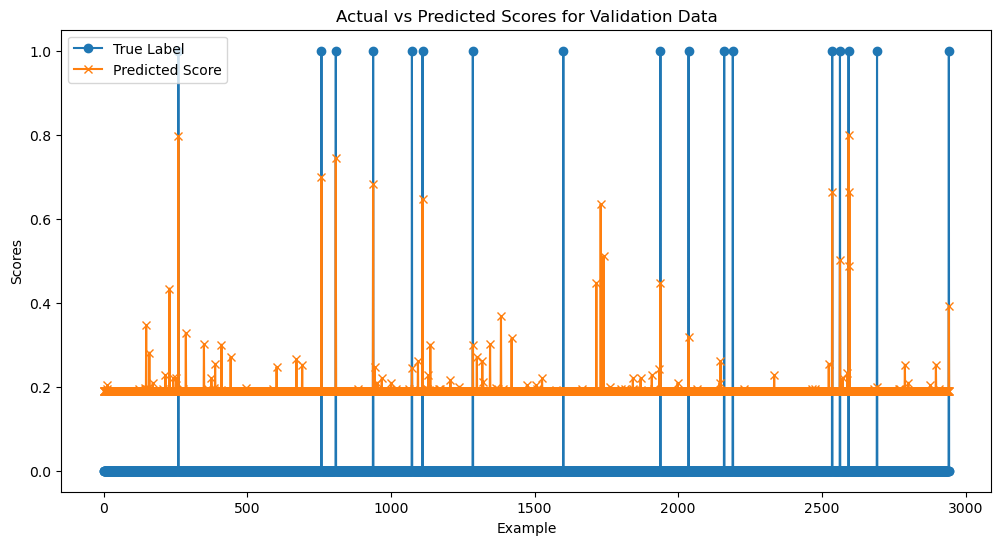

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sample test data
validation_data_uri='s3://bucket-anomadata1/Anoma_Prediction/dataset/validation.csv'
validation_df = pd.read_csv(validation_data_uri)

# Extract features for all data points
payload = validation_df.drop(["y"], axis=1).values.tolist()

# Make predictions using the deployed SageMaker endpoint
prediction_scores = [float(score[0]) for score in predictor.predict(payload)]
true_labels = validation_df['y'].values

# Display the predicted scores and true labels for the first few examples
for i in range(5):
    print(f"Example {i + 1} - Predicted score: {prediction_scores[i]:.3f}, True label: {true_labels[i]}")

# Plot actual vs predicted scores
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(validation_df)), true_labels, label="True Label", marker='o')
plt.plot(np.arange(len(validation_df)), prediction_scores, label="Predicted Score", marker='x')
plt.title("Actual vs Predicted Scores for Validation Data")
plt.xlabel("Example")
plt.ylabel("Scores")
plt.legend()
plt.show()

Accuracy: 0.9959
ROC-AUC: 0.9064


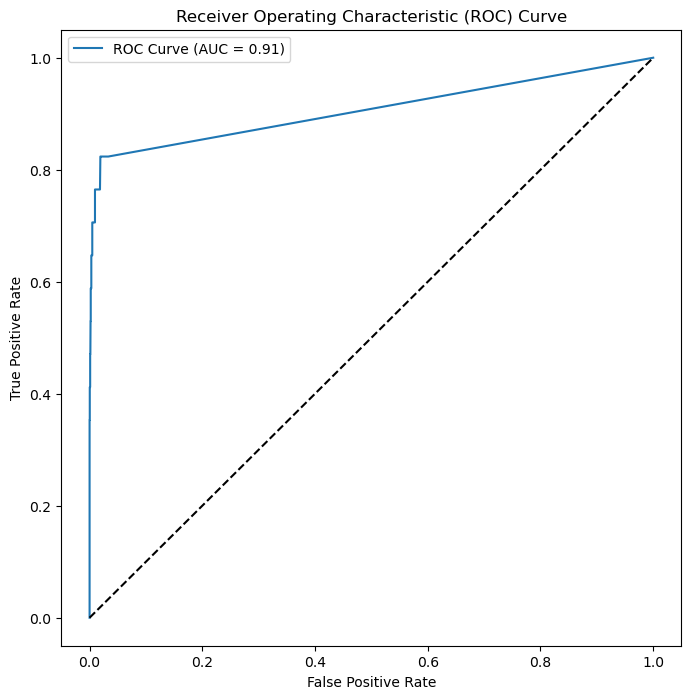

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2927
           1       0.73      0.47      0.57        17

    accuracy                           1.00      2944
   macro avg       0.86      0.73      0.78      2944
weighted avg       1.00      1.00      1.00      2944



In [11]:
# Sample test data
validation_data_uri='s3://bucket-anomadata1/Anoma_Prediction/dataset/validation.csv'
validation_df = pd.read_csv(validation_data_uri)

X_validation = validation_df.drop("y", axis=1)
y_validation = validation_df["y"]



# Extract features for the entire test set
payload_test = X_validation.values.tolist()

# Make predictions using the deployed SageMaker endpoint
prediction_scores_test = [float(score[0]) for score in predictor.predict(payload_test)]


from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

# Evaluate accuracy
accuracy = accuracy_score(y_validation, (np.array(prediction_scores_test) > 0.5).astype(int))
print(f"Accuracy: {accuracy:.4f}")

# Evaluate ROC-AUC score
roc_auc = roc_auc_score(y_validation, prediction_scores_test)
print(f"ROC-AUC: {roc_auc:.4f}")

# Generate and plot ROC curve
fpr, tpr, _ = roc_curve(y_validation, prediction_scores_test)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(y_validation, (np.array(prediction_scores_test) > 0.5).astype(int)))

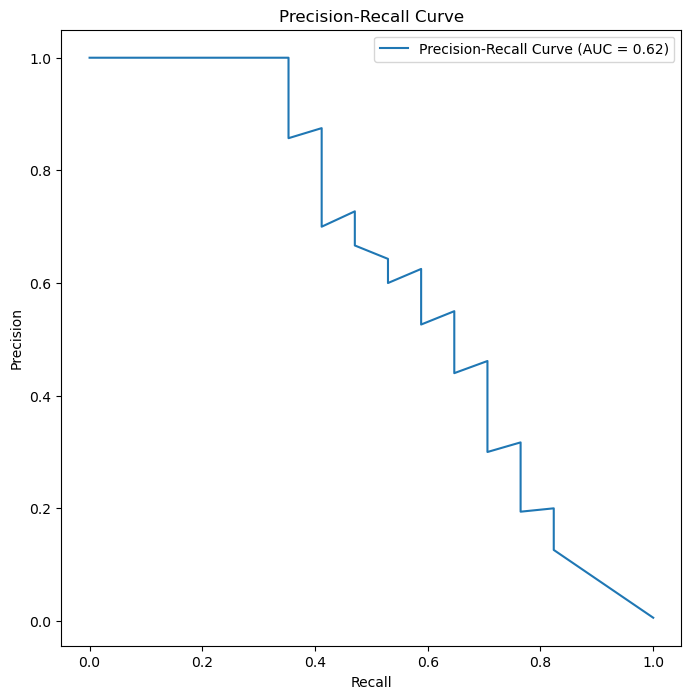

In [12]:
from sklearn.metrics import precision_recall_curve, auc

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_validation, prediction_scores_test)
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


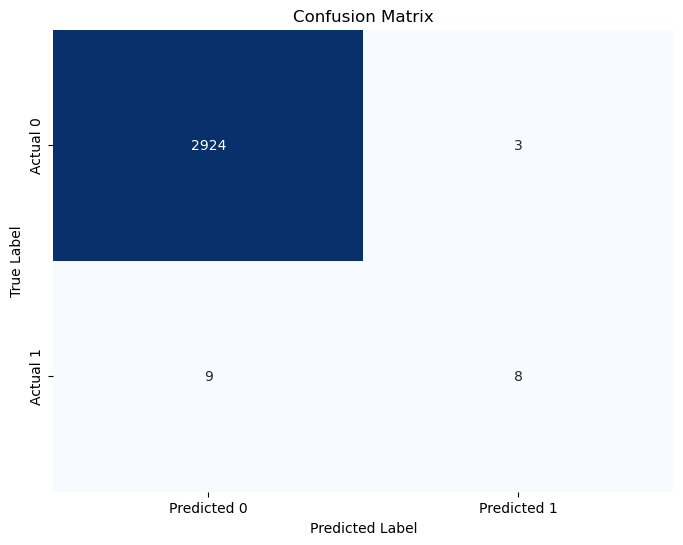

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_validation, (np.array(prediction_scores_test) > 0.5).astype(int))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

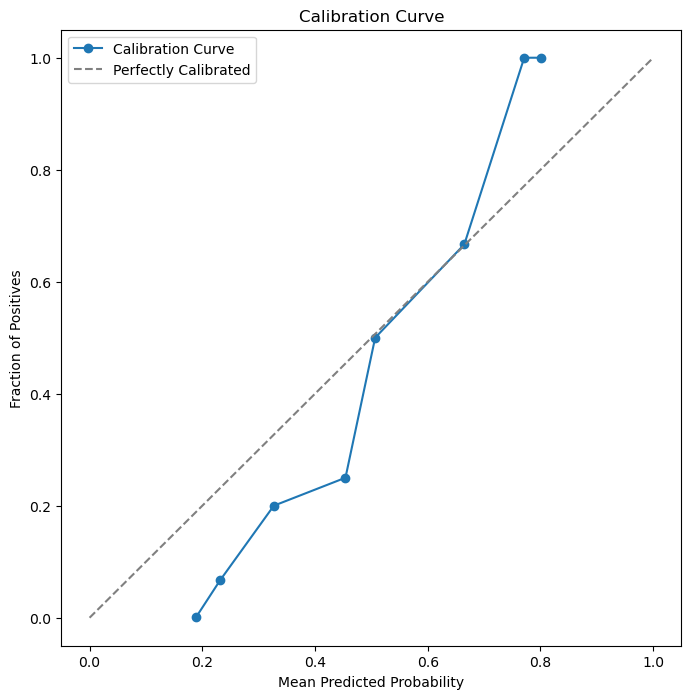

In [14]:
from sklearn.calibration import calibration_curve

# Generate calibration curve
prob_true, prob_pred = calibration_curve(y_validation, prediction_scores_test, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(8, 8))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

## Continuous Improvement

---

Ensuring the ongoing success of our anomaly detection model requires a commitment to continuous improvement. Here are some strategies and considerations for monitoring and enhancing the model's performance:

1. *Monitoring Metrics:* Regularly monitor key performance metrics such as accuracy, ROC-AUC, and other relevant evaluation metrics. Set up automated processes to trigger alerts if there is a significant deviation from expected performance.

2. *Data Drift Detection:* Implement mechanisms to detect data drift, i.e., changes in the statistical properties of the input data. This may involve comparing the distribution of incoming data to the distribution of the training data.

3. *Model Retraining:* Periodically retrain the model using updated data to adapt to evolving patterns in the dataset. Establish a retraining schedule based on the pace of data changes and the sensitivity of the application.

4. *Feedback Mechanism:* If feasible, establish a feedback loop where human feedback or additional labeled data is used to continuously improve the model's understanding of anomalies.

5. *Feature Engineering:* Explore new features or modify existing ones based on domain knowledge or insights gained from ongoing monitoring. Continuous refinement of features can enhance the model's ability to capture subtle patterns.

6. *Integration with External Systems:* If applicable, integrate the anomaly detection model with external systems or workflows to enhance its usability and impact.

7. *Documentation and Collaboration:* Maintain clear documentation of model changes, updates, and improvements. Foster collaboration among team members involved in monitoring and improvement efforts.

8. *Model Versioning:* Implement a versioning system for the model to track changes over time. This ensures reproducibility and facilitates comparisons between different model iterations.

By adopting these continuous improvement strategies, we aim to keep our anomaly detection model resilient and effective in the dynamic environment of predictive maintenance.

## End Note

---
In conclusion, the design and development of the anomaly detection model involved several key choices aimed at achieving optimal performance. The utilization of the XGBoost algorithm, with hyperparameter tuning through SageMaker, allowed for the creation of a robust and efficient model.

### Design Choices:

- *Algorithm Selection:* The XGBoost algorithm was chosen for its ability to handle complex datasets, provide excellent predictive performance, and handle imbalanced class distribution.

- *Hyperparameter Tuning:* The model's hyperparameters were tuned using SageMaker's HyperparameterTuner to optimize performance metrics such as AUC. This ensured the model's ability to generalize well on unseen data.

### Performance Evaluation:

- *Model Metrics:*
  - *Accuracy:* Achieving an accuracy of 99.59% highlights the model's proficiency in correctly classifying instances.
  - *ROC-AUC:* With a ROC-AUC score of 0.9064, the model demonstrates good discriminative ability.

### Future Directions:

- *Continuous Improvement:* Ongoing model monitoring and improvements are crucial. Consider strategies for monitoring model drift, updating the model with new data, and exploring advanced techniques to enhance performance.

- *Discussion of Future Work:* Explore avenues for expanding the model's capabilities, incorporating additional features, and adapting to evolving data patterns.

This model lays the foundation for anomaly detection, and its successful deployment showcases its potential for real-world applications. As we look ahead, a commitment to continuous improvement will ensure the model's effectiveness in dynamic environments.



### Thank You

#### karthik ag